## Verification of Model Forecast vs Observations (Measurements)

Documentation about DMI dat and Scores can be found here:
- https://opendatadocs.dmi.govcloud.dk/APIs/Meteorological_Observation_API
- https://scores.readthedocs.io/en/stable/index.html

Plese define the folling variables to define the data you want to verify.

In [1]:
path_model = "/users/sadamov/pyprojects/neural-lam/data/danra/single_levels.zarr"
url_model = "https://mllam-test-data.s3.eu-north-1.amazonaws.com/single_levels.zarr"
vars_model = {"u10m": "u10", "v10m": "v10"}

path_obs = "/users/sadamov/pyprojects/neural-lam/data/danra/observations.zarr"
url_obs = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"
vars_obs = ["wind_speed_past1h", "wind_dir_past1h"]
api_key = "8dff599e-9a48-46eb-a166-72f2f722645e"

var_plot = "u10"

In [2]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr
from scipy.interpolate import RBFInterpolator
from scores.spatial import fss_2d

For this example the model data is coming from the AWS bucket from DMI for the DANRA reanalysis.

In [3]:
# If the data is not available locally, download it from the cloud
if not os.path.exists(path_model):
    ds_model = xr.open_zarr(url_model)
    chunk_dict = {dim: -1 for dim in ds_model.dims if dim != "time"}
    chunk_dict["time"] = 20
    ds_model = ds_model.chunk(chunk_dict)

    for var in ds_model.variables:
        if "chunks" in ds_model[var].encoding:
            del ds_model[var].encoding["chunks"]

    ds_model.to_zarr(path_model, mode="w")
else:
    ds_model = xr.open_zarr(path_model)

ds_model["time"] = (
    pd.to_datetime(ds_model["time"].values) + pd.DateOffset(years=30)
).to_numpy()  # BUG: Old observation data is not available
ds_model = ds_model[vars_model.keys()]
ds_model = ds_model.rename(vars_model)

ds_model

<xarray.Dataset> Size: 751MB
Dimensions:  (time: 100, y: 589, x: 789)
Coordinates:
    lat      (y, x) float64 4MB dask.array<chunksize=(589, 789), meta=np.ndarray>
    lon      (y, x) float64 4MB dask.array<chunksize=(589, 789), meta=np.ndarray>
  * time     (time) datetime64[ns] 800B 2020-09-01 ... 2020-09-13T09:00:00
  * x        (x) float64 6kB -1.999e+06 -1.997e+06 ... -3.175e+04 -2.925e+04
  * y        (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
Data variables:
    u10      (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    v10      (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
Attributes:
    description:  All prognostic variables for 10-year period on reduced levels

The observations and model data must cover the same timesteps.
Since the example model data hosted on AWS is from 1990 some observations are not available.
For that reason the model data was artificially offset to the year 2020.

In [4]:
datetime_start = np.datetime_as_string(ds_model.time.values[0], unit="s")
datetime_end = np.datetime_as_string(ds_model.time.values[-1], unit="s")
datetime_range = f"{datetime_start}Z/{datetime_end}Z"
print(datetime_range)

2020-09-01T00:00:00Z/2020-09-13T09:00:00Z


In [5]:
dfs = {}

for var in vars_obs:
    params = {
        "api-key": api_key,
        "datetime": datetime_range,
        "parameterId": var,
        "bbox": "7,54,16,58",  # Bounding box for Denmark
        "limit": 100000,
    }

    # Fetch the data
    response = requests.get(url_obs, params=params)
    data = response.json()
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf["time"] = pd.to_datetime(gdf["observed"], utc=True)
    df_pivot = gdf.pivot(index="time", columns="stationId", values="value")
    dfs[var] = df_pivot

time_index = dfs[vars_obs[0]].index.tz_convert(
    None).to_numpy().astype("datetime64[ns]")

# Combine the DataFrames into a single xarray Dataset
ds_obs = xr.Dataset(
    {var: (["time", "stationId"], dfs[var].values) for var in vars_obs},
    coords={
        "time": time_index,
        "stationId": dfs[vars_obs[0]].columns,
        "lat": ("stationId", gdf.groupby("stationId")["geometry"].first().y),
        "lon": ("stationId", gdf.groupby("stationId")["geometry"].first().x),
    },
)

ds_obs = ds_obs.sel(time=ds_model.time)
ds_obs = ds_obs.sortby("time")
ds_obs

<xarray.Dataset> Size: 90kB
Dimensions:            (time: 100, stationId: 55)
Coordinates:
  * time               (time) datetime64[ns] 800B 2020-09-01 ... 2020-09-13T0...
  * stationId          (stationId) object 440B '06019' '06030' ... '06197'
    lat                (stationId) float64 440B 56.93 57.1 57.19 ... 55.3 55.06
    lon                (stationId) float64 440B 8.641 9.851 9.953 ... 14.77 15.1
Data variables:
    wind_speed_past1h  (time, stationId) float64 44kB 0.8 1.0 0.0 ... 10.4 7.8
    wind_dir_past1h    (time, stationId) float64 44kB 107.0 62.0 ... 247.0 242.0

Conversion of wind speed and direction to u and v.

In [6]:
ds_obs["u10"] = ds_obs["wind_speed_past1h"] * np.cos(
    np.radians(90 - ds_obs["wind_dir_past1h"])
)
ds_obs["v10"] = ds_obs["wind_speed_past1h"] * np.sin(
    np.radians(90 - ds_obs["wind_dir_past1h"])
)

Plotting of selected variable

In [7]:
date = ds_obs.isel(time=0)["time"].values
formatted_datetime = pd.to_datetime(date)
formatted_date = formatted_datetime.strftime("%Y-%m-%d")
hour = formatted_datetime.strftime("%H")
title = f"Variable: {var_plot} | Date: {formatted_date} {hour}:00"

Visualization of the observations

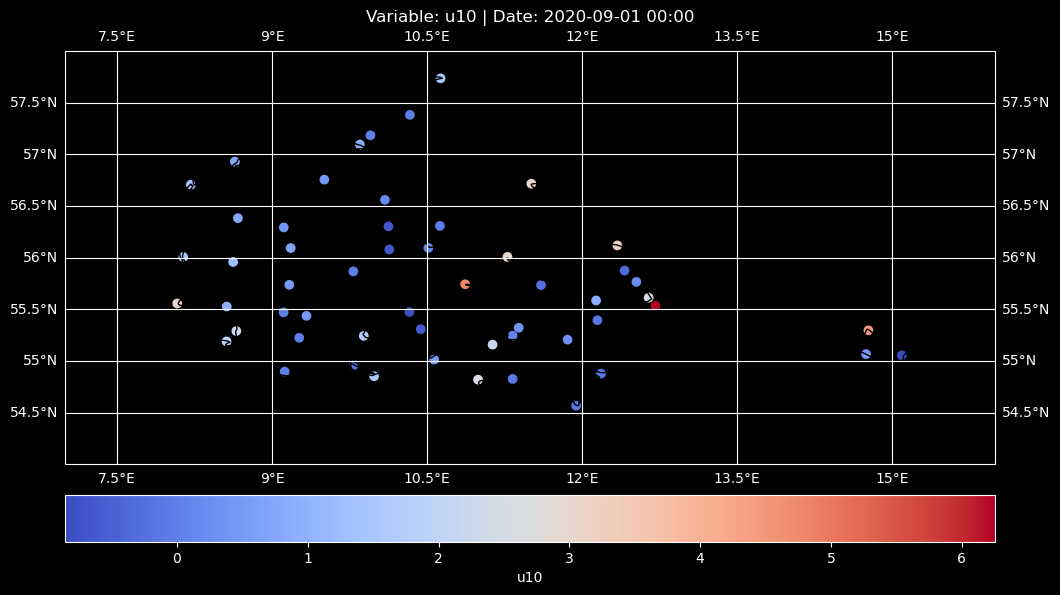

In [8]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={
                       "projection": ccrs.PlateCarree()})

ax.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())

scatter = ax.scatter(
    ds_obs["lon"],
    ds_obs["lat"],
    c=ds_obs.isel(time=0)[var_plot],
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(scatter, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label(var_plot)

plt.title(title)
plt.show()

Visualization of the model data

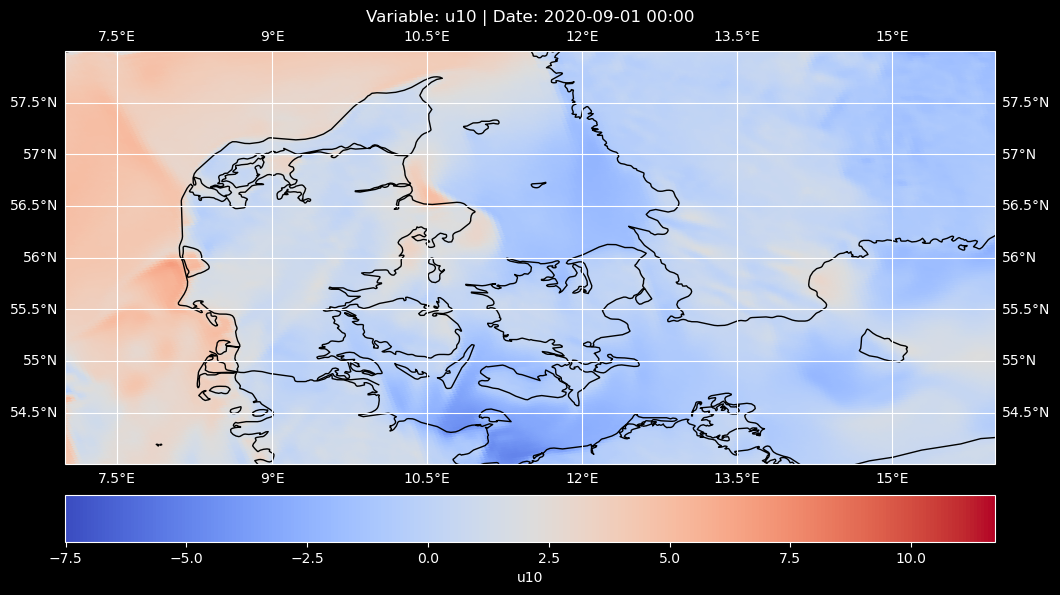

In [9]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())

map = ax.scatter(
    ds_model["lon"],
    ds_model["lat"],
    c=ds_model.isel(time=0)[var_plot],
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(map, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label(var_plot)

plt.title(title)
plt.show()

Interpolation of the model data (gridded) to the observation points.
There are many methods for this, but for this example we will use linear radial basis function interpolation.
For some variables like temperature and humidity vertical height adjustment is needed.

In [10]:
def rbf_interpolate_multi(ds_model, ds_obs, var_names, neighbors=4):
    # Extract model coordinates
    lats_model = ds_model.lat.values.flatten()
    lons_model = ds_model.lon.values.flatten()
    points_model = np.column_stack((lats_model, lons_model))

    # Extract observation coordinates
    lats_obs = ds_obs.lat.values
    lons_obs = ds_obs.lon.values
    points_obs = np.column_stack((lats_obs, lons_obs))

    result = {}
    for var in var_names:
        data_model = ds_model[var].values
        data_obs_shape = ds_obs[var].shape

        interpolated_data = np.zeros(data_obs_shape)

        for t in range(data_obs_shape[0]):  # Loop through time steps
            data_slice = data_model[t].flatten()
            valid_mask = ~np.isnan(data_slice)

            rbf = RBFInterpolator(
                points_model[valid_mask],
                data_slice[valid_mask],
                neighbors=neighbors,
                kernel="linear",
            )

            interpolated_data[t] = rbf(points_obs)

        result[var] = interpolated_data

    return result


vars_to_interpolate = ["u10"]
interpolated = rbf_interpolate_multi(ds_model, ds_obs, vars_to_interpolate)
ds_interpolated = xr.Dataset(
    {var: (["time", "stationId"], interpolated[var]) for var in vars_to_interpolate},
    coords={
        "time": ds_obs.time,
        "stationId": ds_obs.stationId,
        "lat": ds_obs.lat,
        "lon": ds_obs.lon,
    },
)
ds_interpolated

Visualization of the interpolated model data

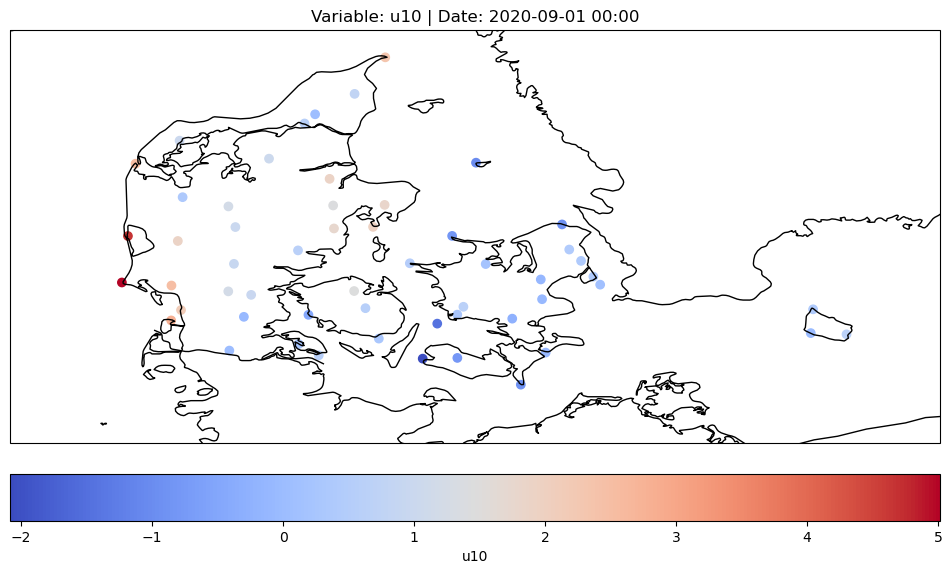

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={
                       "projection": ccrs.PlateCarree()})
ax.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())

map = ax.scatter(
    ds_obs["lon"],
    ds_obs["lat"],
    c=interpolated[var_plot][0],
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

cbar = plt.colorbar(map, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label(var_plot)


plt.title(title)
plt.show()

For the verification with scores the data must contain lat and lon as xarray dimensions.
Here we use masked arrays for this purpose. There might be a better way to do this.

In [ ]:
def convert_2d_to_3d(ds_2d, station_coords):
    lats = station_coords.y.values
    lons = station_coords.x.values
    time_index = ds_2d.time.values

    ds_3d = xr.Dataset()
    for var in ds_2d.data_vars:
        data_3d = np.full((len(time_index), len(lats), len(lons)), np.nan)
        for i, station in enumerate(ds_2d.stationId.values):
            lat_idx = np.where(lats == station_coords.loc[station].y)[0][0]
            lon_idx = np.where(lons == station_coords.loc[station].x)[0][0]
            data_3d[:, lat_idx, lon_idx] = ds_2d[var].sel(
                stationId=station).values

        ds_3d[var] = xr.DataArray(
            data=data_3d, dims=[
                "time", "lat", "lon"], coords={
                "time": time_index, "lat": (
                    "lat", lats), "lon": (
                    "lon", lons)}, )

    return ds_3d


# Convert ds_obs
ds_obs_3d = convert_2d_to_3d(
    ds_obs, gdf.groupby("stationId")["geometry"].first())

# Convert ds_interpolated
ds_interpolated_3d = convert_2d_to_3d(
    ds_interpolated, gdf.groupby("stationId")["geometry"].first()
)

# Mask NaN values
masked_ds_obs_3d = ds_obs_3d.where(~np.isnan(ds_obs_3d), other=0)
masked_ds_interpolated_3d = ds_interpolated_3d.where(
    ~np.isnan(ds_interpolated_3d), other=0
)

Running the verification using the `scores` library.

In [ ]:
fcst = masked_ds_interpolated_3d[var_plot]
obs = masked_ds_obs_3d[var_plot]

# Set the threshold and window size
threshold = 1
window_size = (5, 5)

# Calculate FSS using the scores library
fss_result = fss_2d(
    fcst,
    obs,
    event_threshold=threshold,
    window_size=window_size,
    spatial_dims=("lat", "lon"),
)

print(f"FSS Score: {fss_result.values}")

NameError: name 'masked_ds_interpolated_3d' is not defined